## Custom Functions

In [1]:
# Function to save figures with the given parameters
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    # Loop through each format and save the figure
    for output_format in output_formats:
        fig.savefig(f"{output_dir}/{name}{output_suffix}{output_format}", **savefig_args)
    return None


def plot_custom_dotplot(ad, markers):
    # dot plot creation
    dp = sc.pl.DotPlot(ad, markers, groupby= 'shared', figsize = (2, 2.25), vmax = 2, vmin = 0,  expression_cutoff = 0)
    dp.legend(width=0.8)
    dp.swap_axes()
    dp.add_totals(color = '0.4', size = 0.3,).style(dot_edge_color='black', largest_dot = 40 , dot_edge_lw=0.2, cmap = 'Purples').show()

    # get axes for tweaking out
    axes = dp.get_axes()

    for child in axes['group_extra_ax'].get_children():
        if isinstance(child, mpl.text.Annotation):
            child.set(rotation=90, verticalalignment='bottom')
    # First, remove the current title
    axes['size_legend_ax'].set_title("")
    axes['size_legend_ax'].tick_params(axis='x', which = 'minor', length=0)
    axes['size_legend_ax'].tick_params(axis='x', labelsize=5)

    # Then, create a new title using a text object
    title = "% cells\nexpression > 0"
    axes['size_legend_ax'].text(0, 0.8, title, transform=axes['size_legend_ax'].transAxes, 
                                va='center', ha='left', fontsize = 5)

    title = "Mean Expression\n($log_2$ UMI per 10K)"
    axes['color_legend_ax'].set_title("")
    axes['color_legend_ax'].text(0, 2.2, title, transform=axes['color_legend_ax'].transAxes, 
                                va='center', ha='left', fontsize = 5)
    axes['color_legend_ax'].tick_params(axis='x', labelsize=5)

    # Get the bounding box of the main plot
    mainplot_box = axes['mainplot_ax'].get_position()
    for bar in axes['group_extra_ax'].patches:
        bar.set_edgecolor('none')
    ax = axes['mainplot_ax']
    return dp

NameError: name 'output_dir' is not defined

## Analysis

In [ ]:
# Subset to Memory B cells

adata = sc.read_h5ad(h5ad_file)

mb_adata = adata[adata.obs.celltypist.str.contains('Memory B|Age|Prolif')]
asc_adata = adata[adata.obs.celltypist.str.contains("Plasma")]
print(mb_adata.obs.shape, "Memory B cells to analyze")
print(asc_adata.obs.shape, "Memory B cells to analyze")
mb_adata_LN = mb_adata[mb_adata.obs.tissue == 'LN']

KeyboardInterrupt: 

### Calculate DE genes between the groups to get features for classifier

In [ ]:
use_filtered_genes = True
for tissue_combo in tissue_combo_to_column.keys():
    # Dictionary to hold AnnData objects and their descriptors
    adata_dict = {'all_data': adata, 'mb_cells': mb_adata, 'as_cells':asc_adata, 'LN_only': mb_adata_LN}
    adata_dict = {'mb_cells': mb_adata, 'as_cells':asc_adata, 'LN_only': mb_adata_LN}

    # Loop through the dictionary
    for descriptor, ad in adata_dict.items():        
        ad.obs['shared'] = ad.obs[tissue_combo_to_column[tissue_combo]]
        # restrict to vdjs discovered in either tissue
        print(ad.shape[0], "cells")
        ad.obs['shared'] = ad.obs.shared.astype('category')
        #ad = ad[ad.obs.shared != 'nan']
        ad.obs.shared = ad.obs.shared.cat.remove_unused_categories()
        print(ad.shape[0], "cells after removing nans in shared")
        print("\n", tissue_combo, "\n", descriptor, "\n\n\n\n")
        # Perform ranking of genes
        method = 'wilcoxon'
        #key = f'shared_{method}'
        key = 'rank_genes_groups'
        sc.tl.rank_genes_groups(ad, groupby='shared', method=method, pts=True)
        sc.pl.rank_genes_groups(ad, key = key)
        sc.tl.filter_rank_genes_groups(ad,min_fold_change=0.5, min_in_group_fraction=0.15, max_out_group_fraction=0.8)
        # Plot ranked genes
        #sc.pl.rank_genes_groups(ad, key='rank_genes_groups_filtered')
        
        # Get the DataFrame of ranked genes
        dedf_True = sc.get.rank_genes_groups_df(ad, group="True", key=key)
        dedf_False = sc.get.rank_genes_groups_df(ad, group="False", key=key)
        dedf_filtered_true = sc.get.rank_genes_groups_df(ad, group="True", key='rank_genes_groups_filtered')
        dedf_filtered_false = sc.get.rank_genes_groups_df(ad, group="False", key='rank_genes_groups_filtered')
        # custom dotplot need doc
        if use_filtered_genes:
            true_markers = dedf_filtered_true.dropna(subset = 'names')['names'][:6].to_list()
            false_markers = dedf_filtered_false.dropna(subset = 'names')['names'][:6].to_list()
        else:
            true_markers = dedf_True['names'][:6].to_list()
            false_markers = dedf_False['names'][:6].to_list()
        markers = true_markers + false_markers
        try:
            dp = plot_custom_dotplot(ad, markers)
        except:
            print("Dot plot tried with", len(markers), "could be an issue")
            pass
        # Create a folder for tissue_combo if it doesn't exist
        folder_path = f"../../../data/annotation/{tissue_combo}/{descriptor}/"
        pathlib.Path(folder_path).mkdir(parents=True, exist_ok=True)
        print("created", folder_path)
        # Save dedf_filtered to a file within the tissue_combo folder using f-string for the full path
        dedf_True.to_csv(f"{folder_path}de_genes.tab", sep='\t')
        file_path = f"{folder_path}filtered_de_genes_true.tab"
        dedf_filtered_true.to_csv(file_path, sep = '\t')
        file_path = f"{folder_path}filtered_de_genes_false.tab"
        dedf_filtered_false.to_csv(file_path, sep = '\t')
        folder_path = f"{output_dir}/{tissue_combo}/{descriptor}/"
        pathlib.Path(folder_path).mkdir(parents=True, exist_ok=True)
        print("created", folder_path)

/tmp/ipykernel_11919/236824579.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['shared'] = ad.obs[tissue_combo_to_column[tissue_combo]]


89201 cells
89201 cells after removing nans in shared

 LN_LN 
 mb_cells 






KeyboardInterrupt: 

Loading data...


/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/pandas/core/indexing.py:1728: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


89201 cells
89201 cells after removing nans in shared

LN_SP
mb_cells




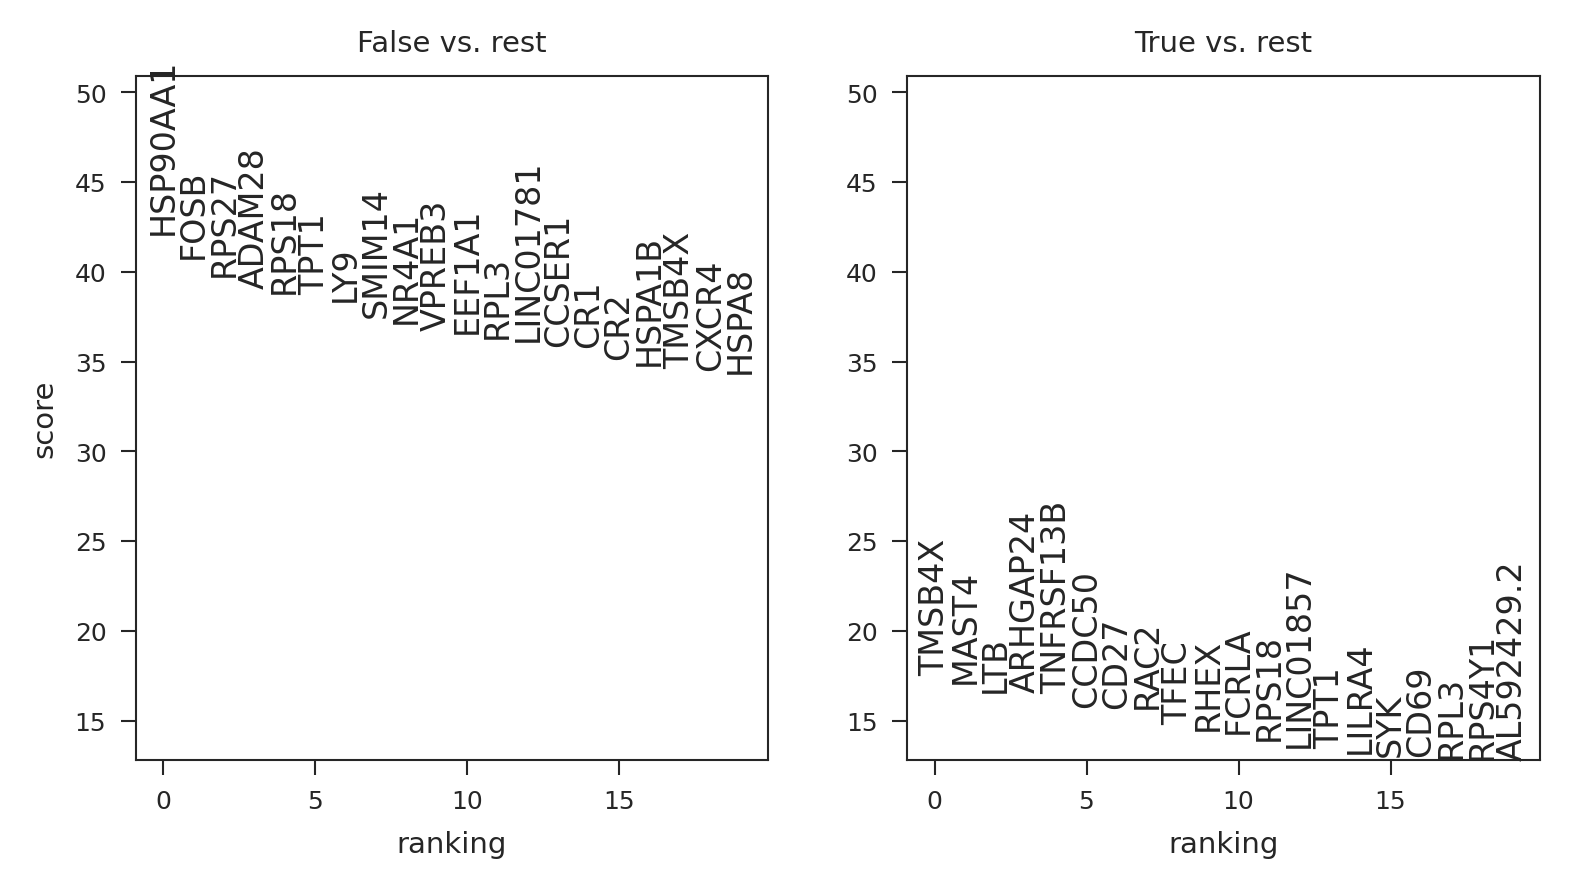

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


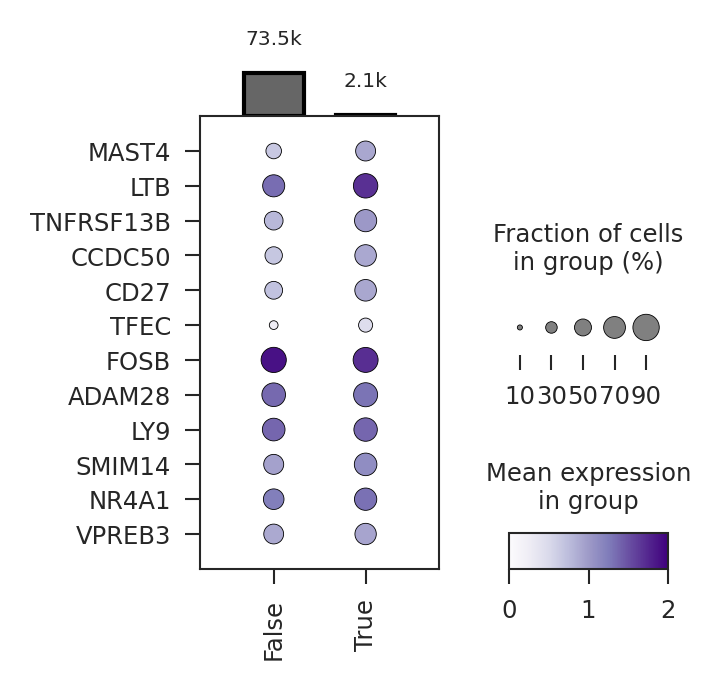

Saved dotplot for LN_SP, mb_cells
Created ../../data/annotation/LN_SP/mb_cells


/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/pandas/core/indexing.py:1728: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


26366 cells
26366 cells after removing nans in shared

LN_SP
as_cells




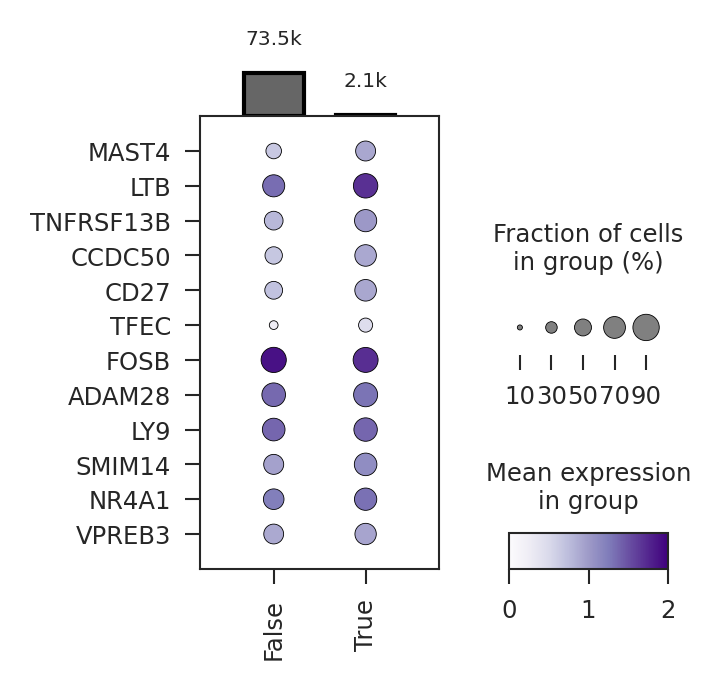

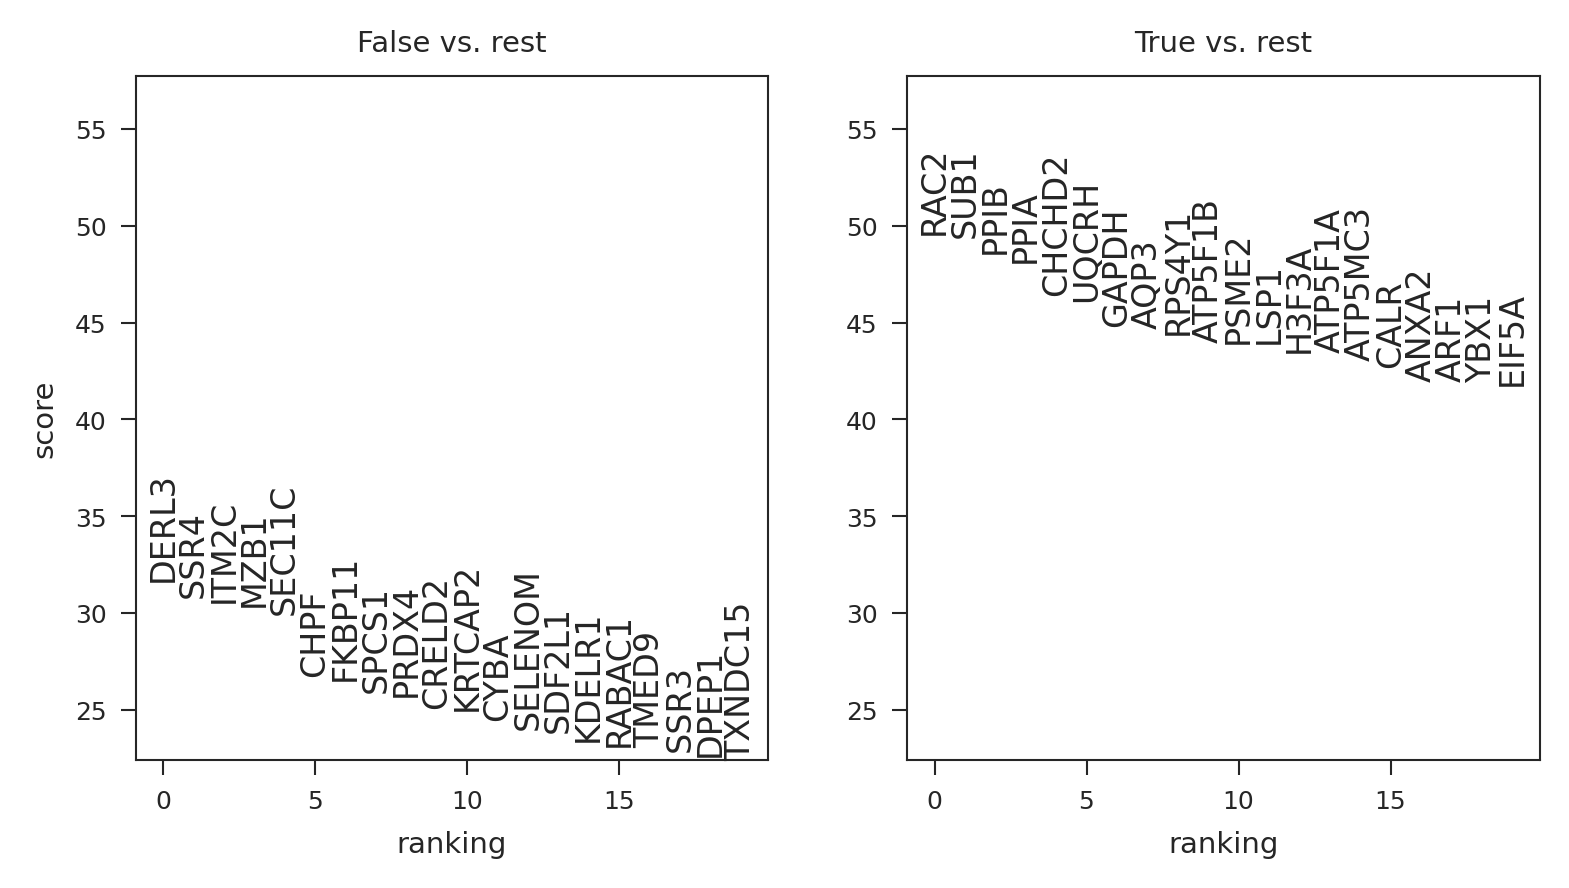

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


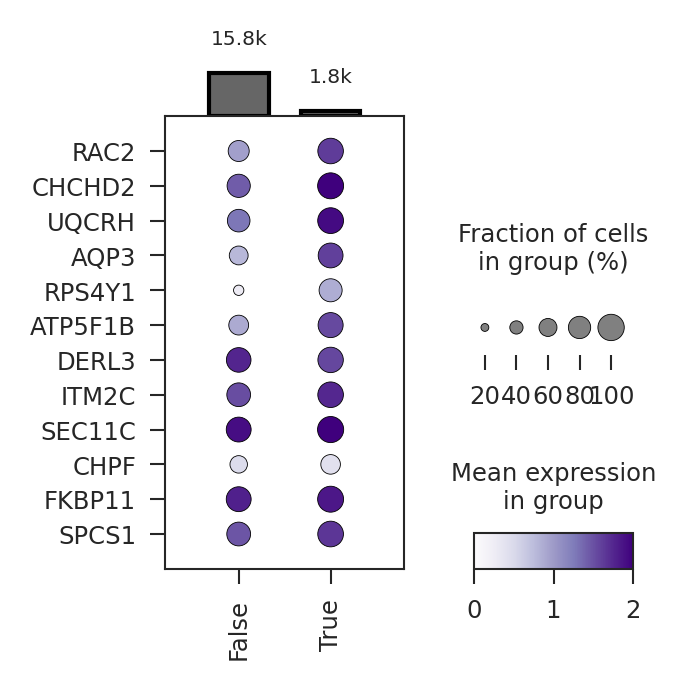

Saved dotplot for LN_SP, as_cells
Created ../../data/annotation/LN_SP/as_cells


/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/pandas/core/indexing.py:1728: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


43590 cells
43590 cells after removing nans in shared

LN_SP
LN_only




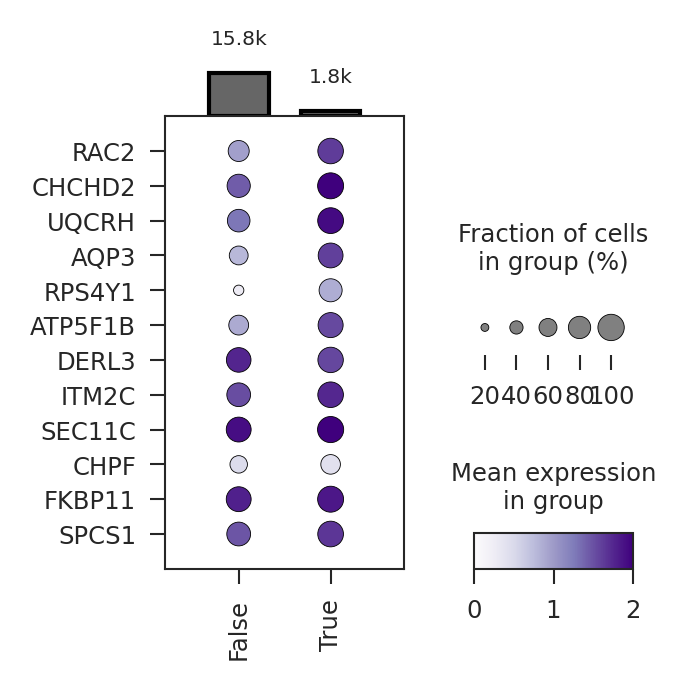

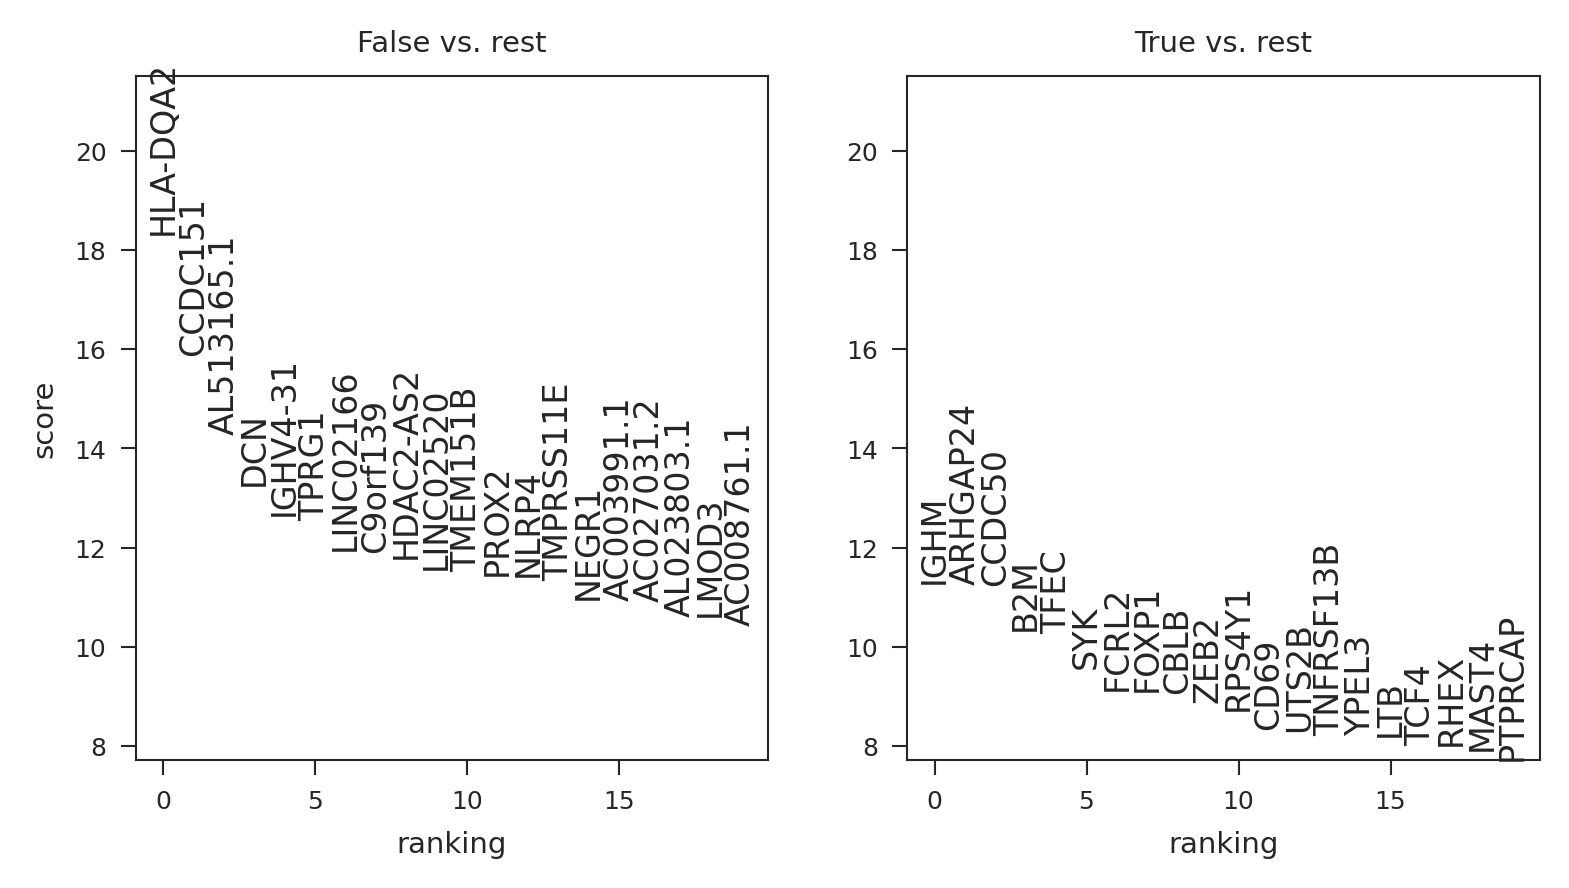

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


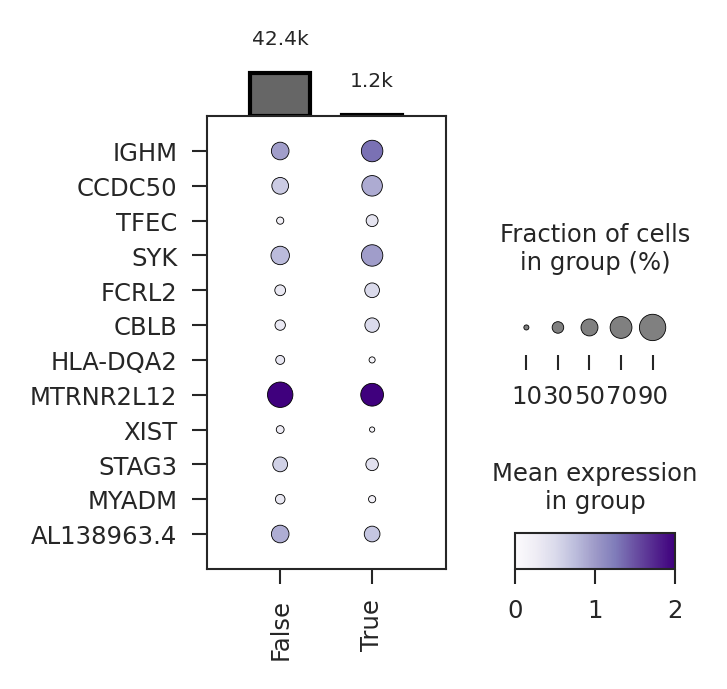

Saved dotplot for LN_SP, LN_only
Created ../../data/annotation/LN_SP/LN_only
Analysis complete. Results saved.


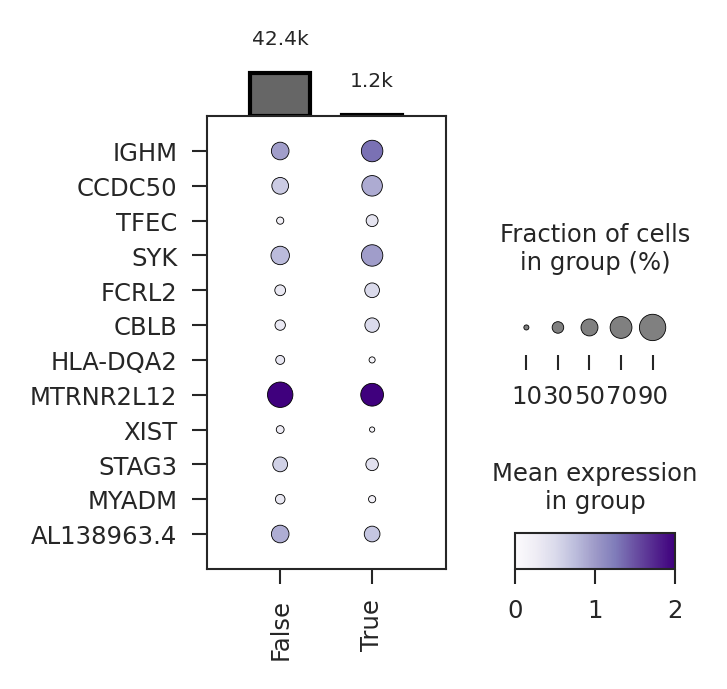

In [ ]:
import pathlib
from typing import List, Dict

import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# Configuration
BASE_DIR = pathlib.Path("..")
DATA_DIR = BASE_DIR / "../data/annotation/sharing"
OUTPUT_DIR = BASE_DIR / "figures/EDFigure11"
SCRIPT_DIR = BASE_DIR / "scripts"
METHOD = "t-test"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
H5AD_FILE = DATA_DIR / "all_sharing.h5ad.gz"
# New configuration for tissue combinations to process

TISSUE_COMBOS_TO_PROCESS = ['LN_SP']  # Add the specific combinations you want, or set to None for all
TISSUE_COMBO_TO_COLUMN = {
    'LN_LN': 'shared_LN_LN',
    'LN_SP': 'shared_LN_SP',
    'LN_PB': 'shared_LN_PB',
    "BM_PB": 'shared_BM_PB',
    "SP_PB": 'shared_SP_PB',
    "SP_BM": 'shared_SP_BM',
    'LN_BM': 'shared_LN_BM',   
}

# Figure settings
SAVEFIG_ARGS = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.1,
    "transparent": True,
}
OUTPUT_FORMATS = [".png", ".pdf"]
OUTPUT_SUFFIX = ""

def setup_plotting():
    """Set up plotting parameters for consistent figure output."""
    mpl.rc("savefig", dpi=300)
    sc.set_figure_params(scanpy=False,
        dpi_save=150,
        frameon=False,
        vector_friendly=True,
        fontsize=6,
        figsize=(3,3),
        format='pdf',
        transparent=True
    )
    sns.set_style("ticks")
    plt.style.use(SCRIPT_DIR / 'bursa.mplstyle')

def plot_custom_dotplot(ad: sc.AnnData, markers: List[str]):
    """Create a custom dot plot for gene expression analysis."""
    dp = sc.pl.DotPlot(ad, markers, groupby='shared', figsize=(2, 2.25), vmax=2, vmin=0, expression_cutoff=0)
    dp.legend(width=0.8)
    dp.swap_axes()
    dp.add_totals(color='0.4', size=0.3).style(dot_edge_color='black', largest_dot=40, dot_edge_lw=0.2, cmap='Purples').show()

    axes = dp.get_axes()

    for child in axes['group_extra_ax'].get_children():
        if isinstance(child, mpl.text.Annotation):
            child.set(rotation=90, verticalalignment='bottom')

    axes['size_legend_ax'].set_title("")
    axes['size_legend_ax'].tick_params(axis='x', which='minor', length=0)
    axes['size_legend_ax'].tick_params(axis='x', labelsize=5)

    title = "% cells\nexpression > 0"
    axes['size_legend_ax'].text(0, 0.8, title, transform=axes['size_legend_ax'].transAxes, 
                                va='center', ha='left', fontsize=5)

    title = "Mean Expression\n($log_2$ UMI per 10K)"
    axes['color_legend_ax'].set_title("")
    axes['color_legend_ax'].text(0, 2.2, title, transform=axes['color_legend_ax'].transAxes, 
                                va='center', ha='left', fontsize=5)
    axes['color_legend_ax'].tick_params(axis='x', labelsize=5)

    for bar in axes['group_extra_ax'].patches:
        bar.set_edgecolor('none')

    return dp

def process_adata(adata: sc.AnnData, tissue_combo: str, descriptor: str, method: str = 'wilcoxon'):
    """Process AnnData object for a specific tissue combination and descriptor."""
    adata.obs.loc[:,'shared'] = adata.obs[TISSUE_COMBO_TO_COLUMN[tissue_combo]]
    print(f"{adata.shape[0]} cells")
    adata.obs['shared'] = adata.obs.shared.astype('category')
    adata.obs.shared = adata.obs.shared.cat.remove_unused_categories()
    print(f"{adata.shape[0]} cells after removing nans in shared")
    print(f"\n{tissue_combo}\n{descriptor}\n\n")

    sc.tl.rank_genes_groups(adata, groupby='shared', method=method, pts=True)
    sc.pl.rank_genes_groups(adata, key='rank_genes_groups')
    sc.tl.filter_rank_genes_groups(adata, min_fold_change=0.7, min_in_group_fraction=0.2, max_out_group_fraction=0.7)

    return adata

def get_markers(adata: sc.AnnData, use_filtered_genes: bool = True):
    """Get marker genes for dotplot."""
    if use_filtered_genes:
        true_markers = sc.get.rank_genes_groups_df(adata, group="True", key='rank_genes_groups_filtered').dropna(subset='names')['names'][:6].tolist()
        false_markers = sc.get.rank_genes_groups_df(adata, group="False", key='rank_genes_groups_filtered').dropna(subset='names')['names'][:6].tolist()
    else:
        true_markers = sc.get.rank_genes_groups_df(adata, group="True", key='rank_genes_groups')['names'][:6].tolist()
        false_markers = sc.get.rank_genes_groups_df(adata, group="False", key='rank_genes_groups')['names'][:6].tolist()
    return true_markers + false_markers

def save_results(adata: sc.AnnData, tissue_combo: str, descriptor: str):
    """Save differential expression results."""
    folder_path = DATA_DIR.parent / tissue_combo / descriptor
    folder_path.mkdir(parents=True, exist_ok=True)
    print(f"Created {folder_path}")

    sc.get.rank_genes_groups_df(adata, group="True", key='rank_genes_groups').to_csv(folder_path / "de_genes.tab", sep='\t')
    sc.get.rank_genes_groups_df(adata, group="True", key='rank_genes_groups_filtered').to_csv(folder_path / "filtered_de_genes_true.tab", sep='\t')
    sc.get.rank_genes_groups_df(adata, group="False", key='rank_genes_groups_filtered').to_csv(folder_path / "filtered_de_genes_false.tab", sep='\t')

def main():
    """Main function to run the analysis pipeline."""
    setup_plotting()

    print("Loading data...")
    adata = sc.read_h5ad(H5AD_FILE)
    mb_adata = adata[adata.obs.celltypist.str.contains('Memory B|Age|Prolif')]
    asc_adata = adata[adata.obs.celltypist.str.contains("Plasma")]
    mb_adata_LN = mb_adata[mb_adata.obs.tissue == 'LN']

    adata_dict = {'mb_cells': mb_adata, 'as_cells': asc_adata, 'LN_only': mb_adata_LN}

    # Determine which tissue combinations to process
    tissue_combos_to_process = TISSUE_COMBOS_TO_PROCESS if TISSUE_COMBOS_TO_PROCESS is not None else TISSUE_COMBO_TO_COLUMN.keys()

    for tissue_combo in tissue_combos_to_process:
        if tissue_combo not in TISSUE_COMBO_TO_COLUMN:
            print(f"Warning: {tissue_combo} is not a valid tissue combination. Skipping.")
            continue

        for descriptor, ad in adata_dict.items():
            ad = process_adata(ad, tissue_combo, descriptor, method=METHOD)
            markers = get_markers(ad)
            
            try:
                dp = plot_custom_dotplot(ad, markers)
                figure_folder = OUTPUT_DIR / tissue_combo / descriptor
                figure_folder.mkdir(parents=True, exist_ok=True)
                for fmt in OUTPUT_FORMATS:
                    dp.savefig(figure_folder / f"dotplot{OUTPUT_SUFFIX}{fmt}", **SAVEFIG_ARGS)
                plt.close()
                print(f"Saved dotplot for {tissue_combo}, {descriptor}")
            except Exception as e:
                print(f"Dot plot failed for {tissue_combo}, {descriptor}. Error: {str(e)}")

            save_results(ad, tissue_combo, descriptor)

    print("Analysis complete. Results saved.")

if __name__ == "__main__":
    main()